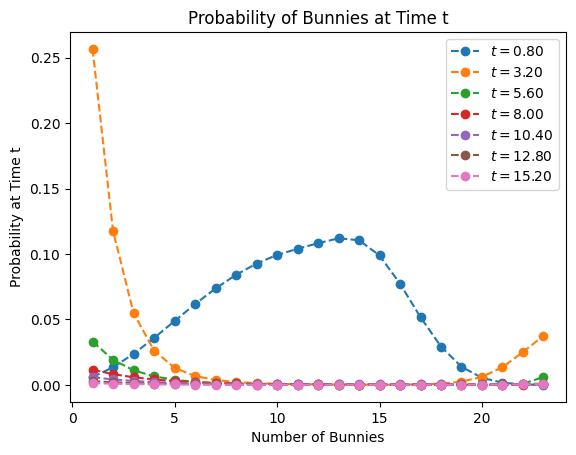

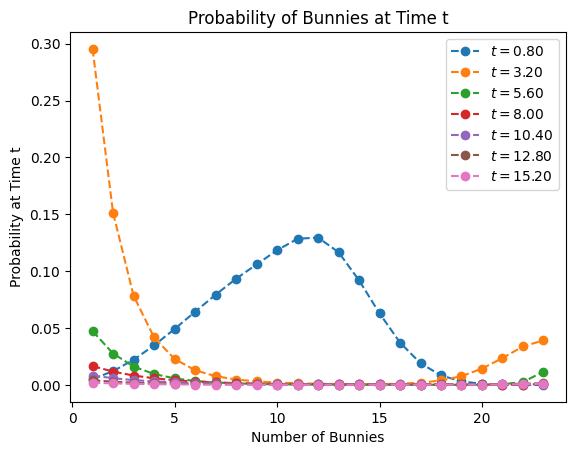

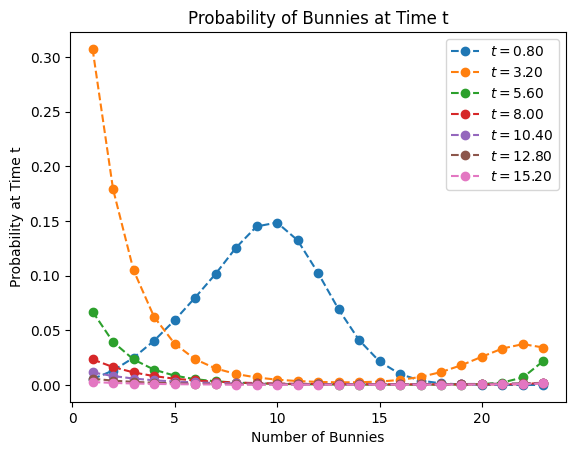

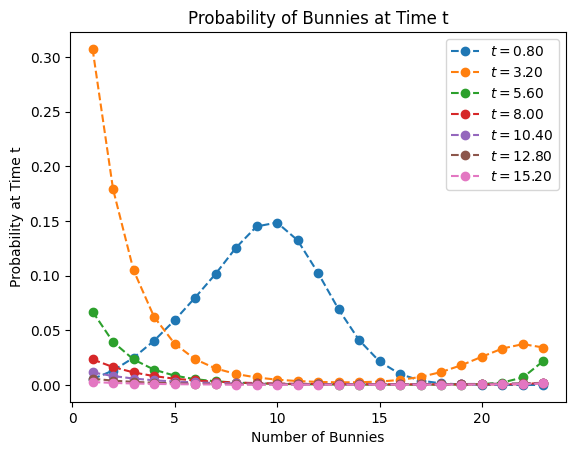

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
plt.style.use(['ggplot'])

# We will use the odeint routine
from scipy.integrate import odeint
# With a wrapper to facilitate 2d arrays
from odeintw import odeintw

# Master Equations
@jit(nopython=True)
def J(x, t, alpha, gamma, beta, delta):
    K = x.shape[0]
    dx = 0 * x
    for n1, n2 in np.ndindex(x.shape):
        dx[n1, n2] -= gamma * n2 * x[n1, n2]  # predator death
        if n1 < K - 1:
            dx[n1, n2] -= alpha * n1 * (K - n1) * x[n1, n2] / K  # prey birth
        if n2 < K - 1:
            dx[n1, n2] -= beta * n1 * n2 * x[n1, n2]  # predation output
        if n1 > 0:
            dx[n1, n2] += alpha * (n1 - 1) * (K - n1 + 1) * x[n1 - 1, n2] / K  # prey birth input
        if n2 < K - 1:
            dx[n1, n2] += gamma * (n2 + 1) * x[n1, n2 + 1]  # predator death input
        if n1 < K - 1 and n2 > 0:
            dx[n1, n2] += beta * (n1 + 1) * (n2 - 1) * x[n1 + 1, n2 - 1]  # predation input

        # Predator birth from predation
        if n2 > 0 and n1 < K - 1 and n2 < K - 1:
            dx[n1, n2] += delta * (n1 + 1) * (n2 - 1) * x[n1 + 1, n2 - 1]

    return dx

# ------------------------------------------

paths = []

# -------------------------------------------
prey_list = [12,10,8,8]

# Time of observations
t_length = 20
t_steps = 25
t_vec = np.linspace(0, t_length, t_steps)
nb_of_states = 25

for prey_count in prey_list:

  # Initial conditions
  x_0 = np.zeros((nb_of_states,nb_of_states))
  x_0[prey_count,1] = 1

  # Parameters
  alpha = 0.8
  gamma = 0.4
  beta = 0.2
  delta = 0.01

  # Integration
  G = lambda x, t: J(x, t, alpha, gamma, beta, delta)
  x_path = odeintw(G, x_0, t_vec)
  paths.append(x_path)

# -------------------------------------------

# Plot
plt.style.use('default')  # cleaner look
for path in paths:
    for t in np.arange(1, 22, 3):
        # Compute marginal over prey and trim endpoints
        prey_probs = np.sum(path[t], axis=1)[1:-1]
        prey_range = range(1, nb_of_states - 1)

        plt.plot(prey_range, prey_probs, marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")

    plt.legend()
    plt.ylabel('Probability at Time t')
    plt.xlabel('Number of Bunnies')
    plt.title('Probability of Bunnies at Time t')
    plt.show()


In [2]:
def get_predator_probability(x, t_query, path, t_vec):
    """
    Returns the probability of exactly `x` predators at time `t_query`.

    Inputs:
        x        - Number of predators to query (int)
        t_query  - Time at which to evaluate (float)
        path     - Output from odeintw (3D: time x prey x predator)
        t_vec    - Time vector used in odeintw
    """
    # Find index in time vector closest to t_query
    t_idx = np.abs(t_vec - t_query).argmin()

    # Sum over prey states to get marginal distribution over predators
    predator_marginal = np.sum(path[t_idx], axis=0)

    # Normalize to ensure total probability = 1
    total = predator_marginal.sum()
    if total > 0:
        predator_marginal /= total

    # Return probability at index x, or 0 if out of bounds
    if 0 <= x < predator_marginal.shape[0]:
        return predator_marginal[x]
    else:
        return 0.0

def get_prey_probability(x, t_query, path, t_vec):
    """
    Returns the probability of exactly `x` prey at time `t_query`.

    Inputs:
        x        - Number of prey to query (int)
        t_query  - Time at which to evaluate (float)
        path     - Output from odeintw (3D: time x prey x predator)
        t_vec    - Time vector used in odeintw
    """
    # Find index in time vector closest to t_query
    t_idx = np.abs(t_vec - t_query).argmin()

    # Sum over predator states to get marginal distribution over prey
    prey_marginal = np.sum(path[t_idx], axis=1)

    # Normalize to ensure total probability = 1
    total = prey_marginal.sum()
    if total > 0:
        prey_marginal /= total

    # Return probability at index x, or 0 if out of bounds
    if 0 <= x < prey_marginal.shape[0]:
        return prey_marginal[x]
    else:
        return 0.0

# Example: probability of exactly 10 predators at time t = 10.0
x_pred = 10
t_query = 10.0
prob = get_predator_probability(x_pred, t_query, paths[0], t_vec)
print(f"Probability of {x_pred} predators at time {t_query}: {prob:.6f}")

# Confirmation: sum over all predator counts should be ~1
sum_prob = sum(get_predator_probability(i, t_query, paths[0], t_vec) for i in range(paths[0].shape[2]))
print("Sum of predator probabilities at t=10:", sum_prob)


Probability of 10 predators at time 10.0: 0.000809
Sum of predator probabilities at t=10: 1.0000000000000002


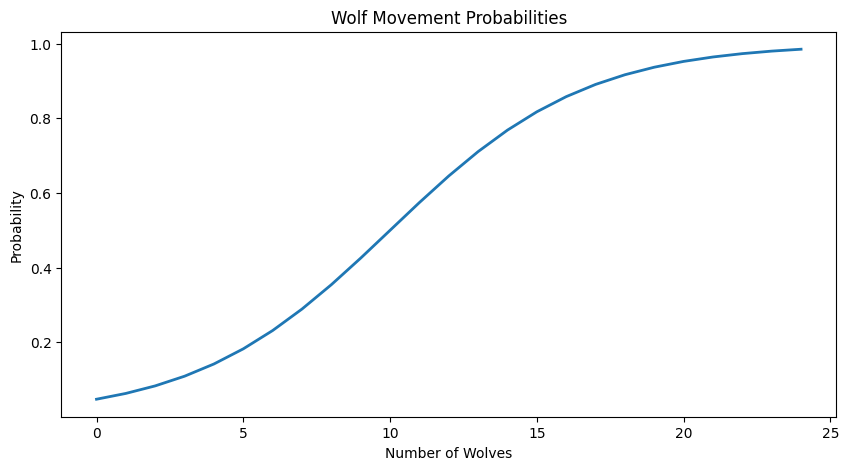

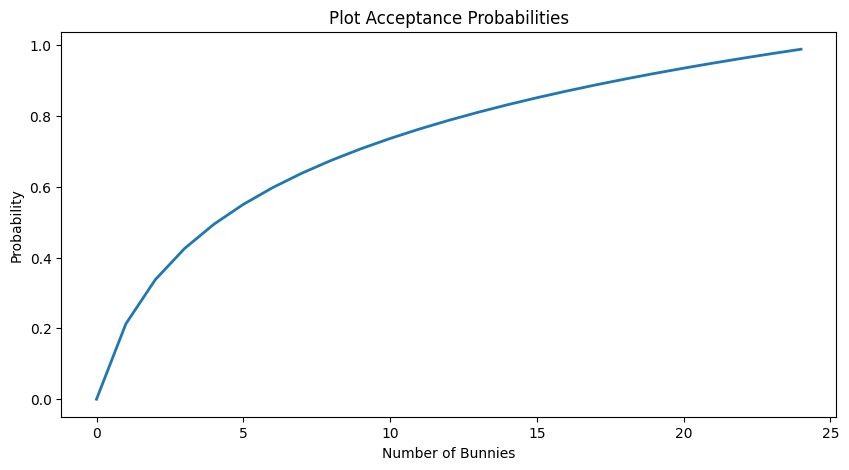

In [3]:
from logging import log
import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['ggplot'])

def predator_leave_prob(n_pred, steepness=0.3, midpoint=10):
    """
    As the number of predators increases, they are more likely to leave.
    Modeled as a standard logistic function.
    """
    return 1 / (1 + np.exp(-steepness * (n_pred - midpoint)))

def predator_accept_prob(n_prey, offset=1):
    """
    Returns a logarithmic predator acceptance probability based on prey count.
    Avoids log(0) by adding an offset (default = 1).
    Scales between 0 and 1 using log normalization.
    """
    return np.log10(n_prey + offset) / np.log10(25 + offset)  # normalize to [0, 1] assuming 100 is max prey


# ------------------------
# Plot Both Functions
# ------------------------

prey_range = np.arange(0, 25)

leave_probs = predator_leave_prob(prey_range)
accept_probs = predator_accept_prob(prey_range)

plt.style.use('default')  # cleaner look
plt.figure(figsize=(10, 5))
plt.plot(prey_range, leave_probs, label="P(predator leaves plot)", lw=2)
plt.xlabel("Number of Wolves")
plt.ylabel("Probability")
plt.title("Wolf Movement Probabilities")
plt.show()

plt.style.use('default')  # cleaner look
plt.figure(figsize=(10, 5))
plt.plot(prey_range, accept_probs, lw=2)
plt.xlabel("Number of Bunnies")
plt.ylabel("Probability")
plt.title("Plot Acceptance Probabilities")
plt.show()


In [4]:
def transmission_rate(n_pred_current, n_prey_next):
    base = predator_leave_prob(n_pred_current)
    modifier = predator_accept_prob(n_prey_next)
    return min(1, max(0, base * modifier))  # Bound it explicitly

4
[np.float64(0.04634715731689744), np.float64(0.17243893873484975), np.float64(0.42318450469865165), np.float64(0.3668805703506473), np.float64(0.25851241563762645), np.float64(0.17531188688140922), np.float64(0.12201780824597179), np.float64(0.09017763588776136), np.float64(0.05985117469982208), np.float64(0.0526210984413141), np.float64(0.047844236893554874), np.float64(0.04453993621065896), np.float64(0.04216236976760654), np.float64(0.03907825553116327), np.float64(0.03807430874404678), np.float64(0.03731183683431468), np.float64(0.03673316050427527), np.float64(0.03629450287003349), np.float64(0.035710448338790654), np.float64(0.03551951365234946), np.float64(0.03537449081696935), np.float64(0.03537449081696935), np.float64(0.03537449081696935), np.float64(0.03537449081696935), np.float64(0.03537449081696935)]


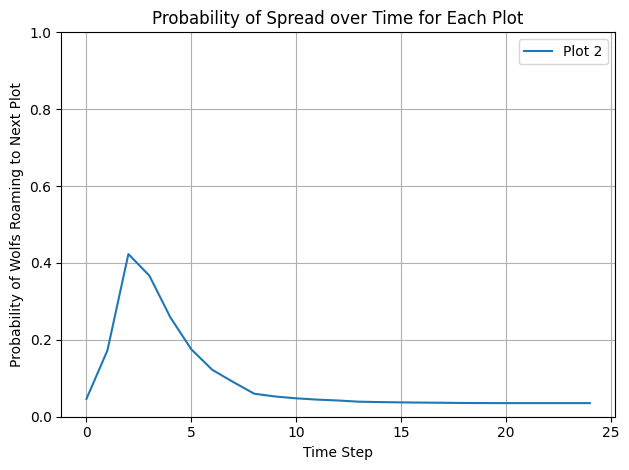

[np.float64(0.04246854076638324), np.float64(0.11750843794096034), np.float64(0.30804259518410493), np.float64(0.32475166092920943), np.float64(0.23917805877778803), np.float64(0.16649139688369652), np.float64(0.1172423565867899), np.float64(0.08688811884958143), np.float64(0.05746322569941386), np.float64(0.05038226874339989), np.float64(0.04566514019144497), np.float64(0.04235798260634117), np.float64(0.039935140134847176), np.float64(0.036699255624684776), np.float64(0.03561299164748762), np.float64(0.03477361202947964), np.float64(0.03412666486375477), np.float64(0.033629442218764405), np.float64(0.03295577221826738), np.float64(0.03273173870208088), np.float64(0.03255987292812556), np.float64(0.03255987292812556), np.float64(0.03255987292812556), np.float64(0.03255987292812556), np.float64(0.03255987292812556)]


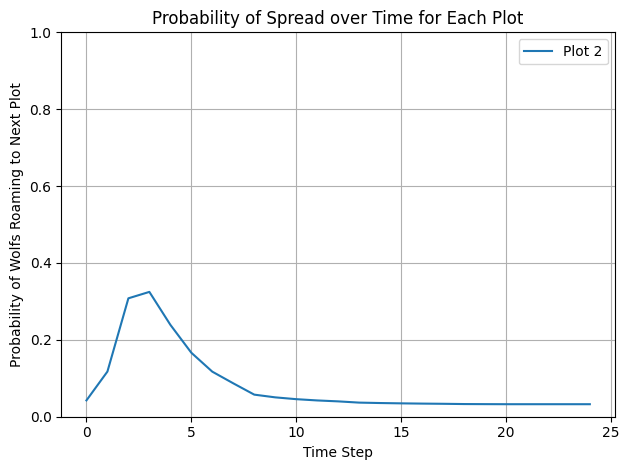

[np.float64(0.04246854076638324), np.float64(0.08737317479494373), np.float64(0.2226254730949059), np.float64(0.3048845864178257), np.float64(0.24056406229602298), np.float64(0.1748214065866263), np.float64(0.12580737858460223), np.float64(0.09385708938817437), np.float64(0.06168610815285827), np.float64(0.05377268548016621), np.float64(0.048442990993824), np.float64(0.04465670165989156), np.float64(0.041839038092025146), np.float64(0.03798235668271454), np.float64(0.0366535500005278), np.float64(0.03561110682055473), np.float64(0.034796533102017926), np.float64(0.03416266931858214), np.float64(0.03329040385532163), np.float64(0.03299598719570576), np.float64(0.03276823505012621), np.float64(0.03276823505012621), np.float64(0.03276823505012621), np.float64(0.03276823505012621), np.float64(0.03276823505012621)]


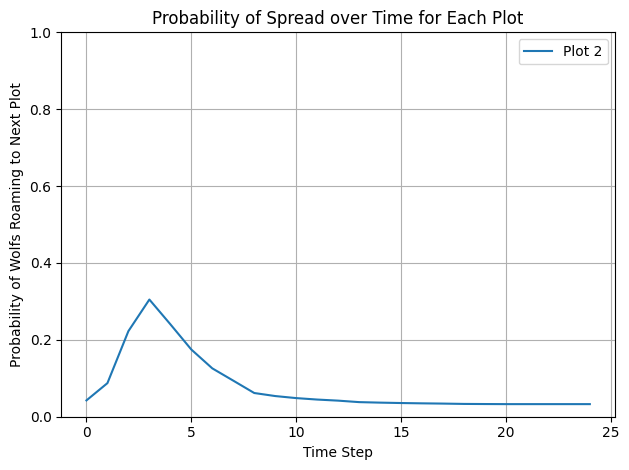

In [5]:
# holds all probability of spread arrays
print(len(paths))
all_ps_arr = []

# for each node
for i in range(len(paths)-1):
  ps_arr = []

  # go through each time step
  for time in range(t_steps):
    sum_probs = 0

    for num_pred in range(nb_of_states):
      p  = get_predator_probability(num_pred, time, paths[i], t_vec)
      r  = transmission_rate(num_pred, prey_list[i+1])
      sum_probs += p * r

    # probability of spread to next plot at current time
    ps_arr.append(sum_probs)

  # add to probability to spread to next plot array (index 1,2,... is the probability of spread from 1->2, 2->3, ...)
  all_ps_arr.append(list(ps_arr))

plt.style.use('default')  # cleaner look
for item in all_ps_arr:
  print(item)
  plt.plot(item, label=f'Plot {i}')
  plt.xlabel('Time Step')
  plt.ylabel('Probability of Wolfs Roaming to Next Plot')
  plt.ylim(0, 1)  # <-- Y-axis scale set here
  plt.title('Probability of Spread over Time for Each Plot')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


In [6]:
from typing_extensions import final
# helper
def sum_lists(x, y):
    result = [a + b for a, b in zip(x, y)]
    return(result)

# helper
def shift_array(arr, num):
    if num <= 0:
        return arr[-num:] + [0]*(-num) if -num < len(arr) else [0]*len(arr)
    return [0]*num + arr[:len(arr) - num]

# helper
def divide_array(arr, divisor):
    return [x / divisor for x in arr]

# helper
import numbers
import numpy as np

def mult_arrays(a, b):
    if isinstance(b, (int, float, np.number)):  # include numpy numbers
        return [x * b for x in a]
    elif isinstance(b, list):
        if len(a) != len(b):
            raise ValueError("Both lists must be the same length")
        return [x * y for x, y in zip(a, b)]
    else:
        raise TypeError(f"Unsupported type for b: {type(b)}")

def normalize(arr):
    total = sum(arr)
    return [x / total for x in arr] if total > 0 else arr




final_prob_spread = []
final_prob_spread.append(all_ps_arr[0])  # first plot already computed

for i in range(1, len(all_ps_arr)):
    new_spread_arr = [0] * t_steps
    prev_distribution = final_prob_spread[i - 1]

    for t in range(t_steps):
        weighted = mult_arrays(all_ps_arr[i], prev_distribution[t])  # scale
        shifted = shift_array(weighted, t)                            # then shift
        new_spread_arr = sum_lists(new_spread_arr, shifted)

    new_spread_arr = normalize(new_spread_arr)
    final_prob_spread.append(new_spread_arr)


# Print results
for i, arr in enumerate(final_prob_spread):
    print(f"Plot {i}: {arr}")

final_prob_spread = [np.array(p) / np.sum(p) if np.sum(p) > 0 else np.array(p) for p in final_prob_spread]


Plot 0: [np.float64(0.04634715731689744), np.float64(0.17243893873484975), np.float64(0.42318450469865165), np.float64(0.3668805703506473), np.float64(0.25851241563762645), np.float64(0.17531188688140922), np.float64(0.12201780824597179), np.float64(0.09017763588776136), np.float64(0.05985117469982208), np.float64(0.0526210984413141), np.float64(0.047844236893554874), np.float64(0.04453993621065896), np.float64(0.04216236976760654), np.float64(0.03907825553116327), np.float64(0.03807430874404678), np.float64(0.03731183683431468), np.float64(0.03673316050427527), np.float64(0.03629450287003349), np.float64(0.035710448338790654), np.float64(0.03551951365234946), np.float64(0.03537449081696935), np.float64(0.03537449081696935), np.float64(0.03537449081696935), np.float64(0.03537449081696935), np.float64(0.03537449081696935)]
Plot 1: [np.float64(0.00048155353110773745), np.float64(0.0031241007846711617), np.float64(0.012847313963319812), np.float64(0.03265618190176482), np.float64(0.061539

In [7]:
# Convert each infection PDF into a CDF using cumulative sum
cdf_prob_spread = []
for pdf in final_prob_spread:
    # Optional: Clip negative values to prevent CDF issues
    pdf = [max(p, 0) for p in pdf]

    # Normalize PDF to make sure it sums to 1 (optional but recommended)
    total = sum(pdf)
    if total > 0:
        pdf = [x / total for x in pdf]

    # Cumulative sum to get CDF
    cdf = np.cumsum(pdf).tolist()
    cdf_prob_spread.append(cdf)

# Print CDFs
for i, arr in enumerate(cdf_prob_spread):
    print(f"CDF for Plot {i}: {arr}")


CDF for Plot 0: [0.01982779478587822, 0.09359896195695915, 0.27464168391628896, 0.4315969985669773, 0.5421912922324434, 0.6171915364295641, 0.6693920208213375, 0.7079709491131552, 0.7335759026495214, 0.7560877545451603, 0.7765560155072299, 0.7956106623526163, 0.8136481616046715, 0.8303662447864316, 0.84665482911598, 0.8626172200513403, 0.878332047248519, 0.8938592121583747, 0.9091365124797711, 0.9243321289612207, 0.9394657031689766, 0.9545992773767324, 0.9697328515844883, 0.9848664257922441, 1.0]
CDF for Plot 1: [0.00048155353110773756, 0.0036056543157789002, 0.016452968279098715, 0.049109150180863544, 0.11064823425159528, 0.19315260009321678, 0.2812089210156065, 0.36404280508555587, 0.4369089456985397, 0.4989706503743319, 0.5507438797600107, 0.5948551250538681, 0.6338867426796735, 0.6695969270705104, 0.7030623739459242, 0.7348667807042167, 0.7655617616663186, 0.7955320644439385, 0.8250453557371145, 0.8542802109825655, 0.8833457239944523, 0.9123623477006695, 0.9414253060970497, 0.97061

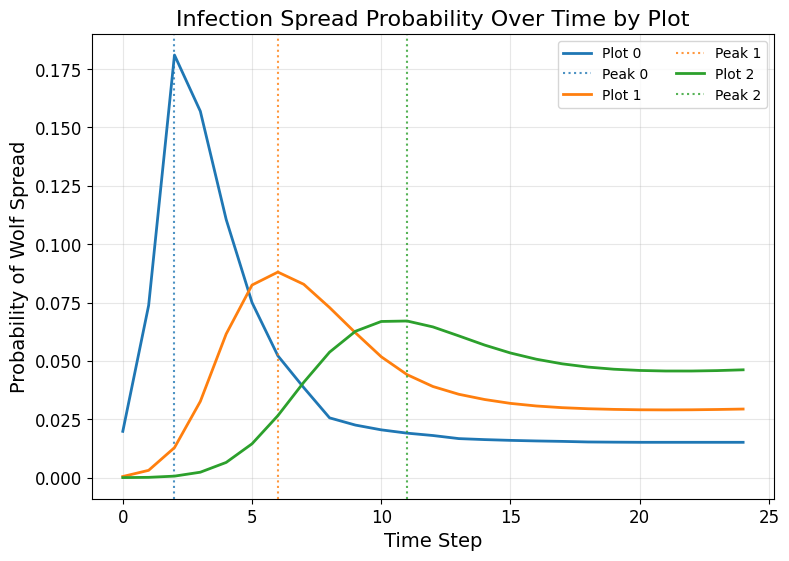

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x = list(range(t_steps))
width = 8
height = width / 1.4
plt.figure(figsize=(width, height))
plt.style.use('default')  # cleaner look

for i, arr in enumerate(final_prob_spread):
    arr = np.array(arr)
    arr = arr / np.sum(arr) if np.sum(arr) > 0 else arr

    peak_t = np.argmax(arr)  # index of max value

    plt.plot(x, arr, label=f'Plot {i}', linewidth=2)
    plt.axvline(peak_t, color=f'C{i}', linestyle=':', alpha=0.8, linewidth=1.5, label=f'Peak {i}')

plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Probability of Wolf Spread', fontsize=14)
plt.title('Infection Spread Probability Over Time by Plot', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=10, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
